In [1]:
! pip install -r requirements.txt

In [2]:
import os
import pandas as pd

# Adjust this to your dataset path
base_path = './dataset'

# Prepare list for metadata
data = []

# Loop through train and test folders
for split in ['train', 'test']:
    images_path = os.path.join(base_path, split, 'images')
    for filename in os.listdir(images_path):
        if not filename.lower().endswith(('.jpg', '.png', '.jpeg', '.tif')):
            continue
        
        cell_type = 'Unknown'
        experiment = 'Unknown'

        # Cell type detection
        if filename.startswith('MRC-5'):
            cell_type = 'MRC-5'
            # Extract experiment from _E02_...
            parts = filename.split('_')
            for p in parts:
                if p.startswith('E'):
                    experiment = p
                    break
        elif filename.startswith('MiaPaca-2'):
            cell_type = 'MiaPaca-2'
            parts = filename.split('_')
            for p in parts:
                if p.startswith('E'):
                    experiment = p
                    break
        elif filename.startswith('UFH-001'):
            cell_type = 'UFH-001'
            parts = filename.split('_')
            # Join parts from index 1 to index 4 (Control_2_Pozice_23)
            experiment = "_".join(parts[1:2])
        elif 'low glucose' in filename or 'Ex' in filename:
            cell_type = 'U2OS'
            if 'Ex' in filename:
                parts = filename.split('Ex')
                if len(parts) > 1:
                    exp_part = parts[1].strip().split('_')[0]
                    experiment = f'Ex {exp_part}'

        # Append metadata
        data.append({
            'filename': filename,
            'split': split,
            'cell_type': cell_type,
            'experiment': experiment
        })

# Create DataFrame
df = pd.DataFrame(data)
df.head()

,filename,split,cell_type,experiment
0,"5min, low glucose, 5% FBS, Ex 01_137.jpg",train,U2OS,Ex 01
1,MiaPaca-2_E01_D5_108.jpg,train,MiaPaca-2,E01
2,"5min, low glucose, 5% FBS, Ex 01_013.jpg",train,U2OS,Ex 01
3,MiaPaca-2_E01_D5_081.jpg,train,MiaPaca-2,E01
4,MiaPaca-2_E01_D5_050.jpg,train,MiaPaca-2,E01


In [3]:
print(df['cell_type'].value_counts())
print(df.groupby(['cell_type', 'experiment']).size())

cell_type
U2OS         200
MiaPaca-2    147
UFH-001       52
MRC-5         46
Name: count, dtype: int64
cell_type  experiment
MRC-5      E02            46
MiaPaca-2  E01           147
U2OS       Ex 01         150
           Ex 02          25
           Ex 07          25
UFH-001    Control        52
dtype: int64


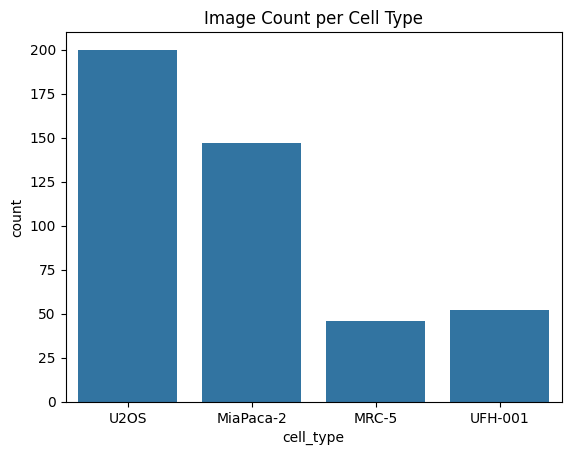

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='cell_type', data=df)
plt.title('Image Count per Cell Type')
plt.show()

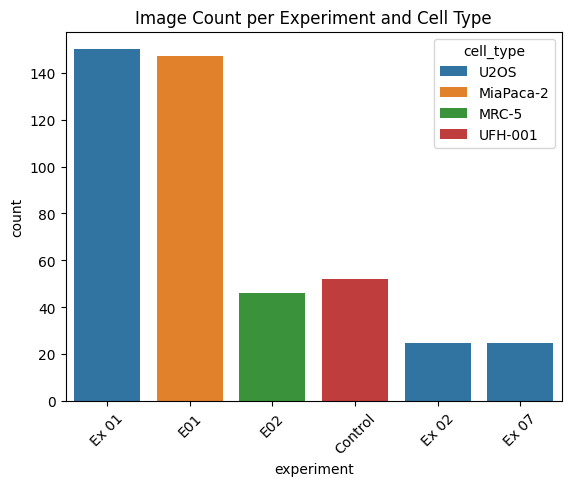

In [6]:
sns.countplot(x='experiment', hue='cell_type', data=df)
plt.title('Image Count per Experiment and Cell Type')
plt.xticks(rotation=45)
plt.show()

In [7]:
from PIL import Image
import numpy as np
from tqdm import tqdm

# Prepare lists for features
mean_intensity = []
std_intensity = []
height = []
width = []

# Loop through DataFrame and process images
for idx, row in tqdm(df.iterrows(), total=len(df)):
    # Full image path
    img_path = os.path.join(base_path, row['split'], 'images', row['filename'])
    
    # Open image and convert to grayscale
    img = Image.open(img_path).convert('L')  # 'L' mode = grayscale
    img_array = np.array(img)
    
    # Extract features
    mean_intensity.append(img_array.mean())
    std_intensity.append(img_array.std())
    height.append(img_array.shape[0])
    width.append(img_array.shape[1])

# Add features to DataFrame
df['mean_intensity'] = mean_intensity
df['std_intensity'] = std_intensity
df['height'] = height
df['width'] = width

df.head()

100%|██████████| 445/445 [00:34<00:00, 13.03it/s]


,filename,split,cell_type,experiment,mean_intensity,std_intensity,height,width
0,"5min, low glucose, 5% FBS, Ex 01_137.jpg",train,U2OS,Ex 01,123.125921,5.754792,2048,2048
1,MiaPaca-2_E01_D5_108.jpg,train,MiaPaca-2,E01,95.142227,13.826494,2048,2048
2,"5min, low glucose, 5% FBS, Ex 01_013.jpg",train,U2OS,Ex 01,165.375315,7.778029,2048,2048
3,MiaPaca-2_E01_D5_081.jpg,train,MiaPaca-2,E01,96.885921,13.235975,2048,2048
4,MiaPaca-2_E01_D5_050.jpg,train,MiaPaca-2,E01,99.234862,11.548096,2048,2048


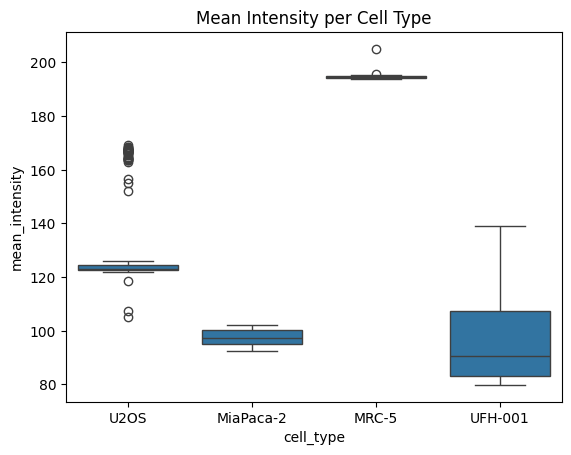

In [8]:
sns.boxplot(x='cell_type', y='mean_intensity', data=df)
plt.title('Mean Intensity per Cell Type')
plt.show()

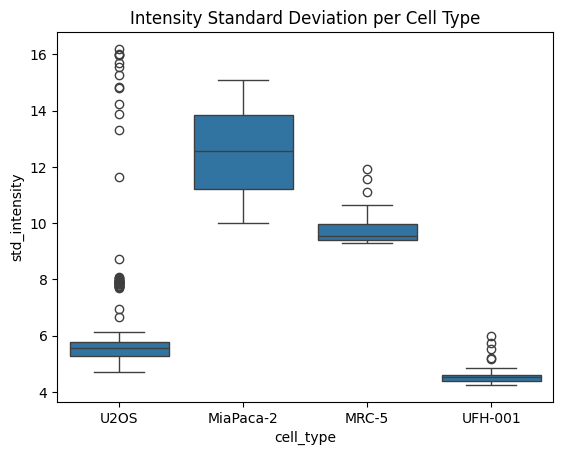

In [9]:
sns.boxplot(x='cell_type', y='std_intensity', data=df)
plt.title('Intensity Standard Deviation per Cell Type')
plt.show()

--- max_depth: 5 ---
              precision    recall  f1-score   support

       MRC-5       1.00      1.00      1.00        14
   MiaPaca-2       1.00      1.00      1.00        44
        U2OS       0.97      0.98      0.98        60
     UFH-001       0.93      0.88      0.90        16

    accuracy                           0.98       134
   macro avg       0.98      0.96      0.97       134
weighted avg       0.98      0.98      0.98       134

--- max_depth: 10 ---
              precision    recall  f1-score   support

       MRC-5       1.00      1.00      1.00        14
   MiaPaca-2       1.00      1.00      1.00        44
        U2OS       0.97      0.98      0.98        60
     UFH-001       0.93      0.88      0.90        16

    accuracy                           0.98       134
   macro avg       0.98      0.96      0.97       134
weighted avg       0.98      0.98      0.98       134

--- max_depth: None ---
              precision    recall  f1-score   support

       M

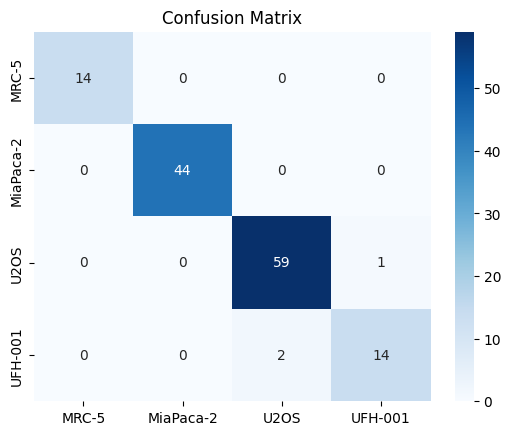

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Select features and target
features = df[['mean_intensity', 'std_intensity']]
target = df['cell_type']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42, stratify=target)

# Random Forest with basic hyperparameters
for depth in [5, 10, None]:
    rf = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print(f'--- max_depth: {depth} ---')
    print(classification_report(y_test, y_pred))

# Predictions
y_pred = rf.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title('Confusion Matrix')
plt.show()


In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Features only
X = df[['mean_intensity', 'std_intensity']]

# Try different cluster counts
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    score = silhouette_score(X, cluster_labels)
    print(f'Clusters: {k}, Silhouette Score: {score:.2f}')

Clusters: 2, Silhouette Score: 0.76
Clusters: 3, Silhouette Score: 0.79
Clusters: 4, Silhouette Score: 0.83
Clusters: 5, Silhouette Score: 0.81
Clusters: 6, Silhouette Score: 0.77


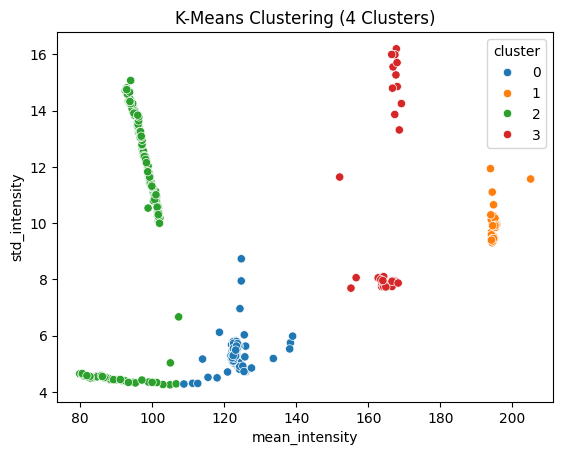

In [12]:
kmeans = KMeans(n_clusters=4, n_init=20, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

sns.scatterplot(x='mean_intensity', y='std_intensity', hue='cluster', data=df, palette='tab10')
plt.title('K-Means Clustering (4 Clusters)')
plt.show()